<a href="https://colab.research.google.com/github/Anvians/Deep_Learning/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [8]:
from torch.utils.data import Dataset, DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]


In [62]:
import torch
import torch.nn as nn

class CnnModel(nn.Module):
    def __init__(self, num_classes, in_channels, out_channels):
        super(CnnModel, self).__init__()
        self.layer1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(in_channels=out_channels, out_channels=2*out_channels, kernel_size=3, padding=1)

        self.fc_layer1 = nn.Linear(in_features=2*out_channels*7*7, out_features=500)
        self.fc_layer2 = nn.Linear(in_features=500, out_features=num_classes, bias=True)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.maxpool(out)
        out = self.relu(self.layer2(out))
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.relu(self.fc_layer1(out))
        out = self.dropout(out)
        out = self.fc_layer2(out)
        return out


In [63]:
model = CnnModel(num_classes=10, in_channels=1, out_channels=16)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
#accuracy function
def accuracy(y_pred, y):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y).float()
  acc = correct_pred.sum() / len(correct_pred)
  return acc

In [71]:
def Train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    total_acc = 0
    total_samples = 0  # Track total samples for averaging accuracy

    for batch_idx, (image, label) in enumerate(train_loader):
        y_pred = model(image)  # Corrected model call
        loss = criterion(y_pred, label)
        acc = accuracy(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc.item() * label.size(0)  # Weight accuracy by batch size
        total_samples += label.size(0)  # Track total samples
        if batch_idx % 100 == 0:
          print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}')


    return total_loss / len(train_loader), total_acc / total_samples  # Average loss & accuracy


In [86]:
def Test(model, ten_image):

  model.eval()
  with torch.inference_mode():
    y_pred = model(ten_image)

  return y_pred


In [77]:
for epoch in range(2):
  train_loss, train_acc = Train(model, train_loader, criterion, optimizer, epoch)
  print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')


Epoch: 0, Batch: 0, Loss: 0.0083, Accuracy: 1.0000
Epoch: 0, Batch: 100, Loss: 0.0004, Accuracy: 1.0000
Epoch: 0, Batch: 200, Loss: 0.0060, Accuracy: 1.0000
Epoch: 0, Batch: 300, Loss: 0.0015, Accuracy: 1.0000
Epoch: 0, Batch: 400, Loss: 0.0001, Accuracy: 1.0000
Epoch: 0, Batch: 500, Loss: 0.0716, Accuracy: 0.9688
Epoch: 0, Batch: 600, Loss: 0.0209, Accuracy: 0.9844
Epoch: 0, Batch: 700, Loss: 0.0162, Accuracy: 0.9844
Epoch: 0, Batch: 800, Loss: 0.0029, Accuracy: 1.0000
Epoch: 0, Batch: 900, Loss: 0.0037, Accuracy: 1.0000
Epoch: 0, Train Loss: 0.0125, Train Accuracy: 0.9960, Test Loss: 0.0257, Test Accuracy: 0.9931
Epoch: 1, Batch: 0, Loss: 0.0008, Accuracy: 1.0000
Epoch: 1, Batch: 100, Loss: 0.0000, Accuracy: 1.0000
Epoch: 1, Batch: 200, Loss: 0.0001, Accuracy: 1.0000
Epoch: 1, Batch: 300, Loss: 0.0007, Accuracy: 1.0000
Epoch: 1, Batch: 400, Loss: 0.0431, Accuracy: 0.9844
Epoch: 1, Batch: 500, Loss: 0.0001, Accuracy: 1.0000
Epoch: 1, Batch: 600, Loss: 0.0034, Accuracy: 1.0000
Epoch: 1

In [91]:
image, label = next(iter(test_loader))

In [92]:
ten_image = image[:50]


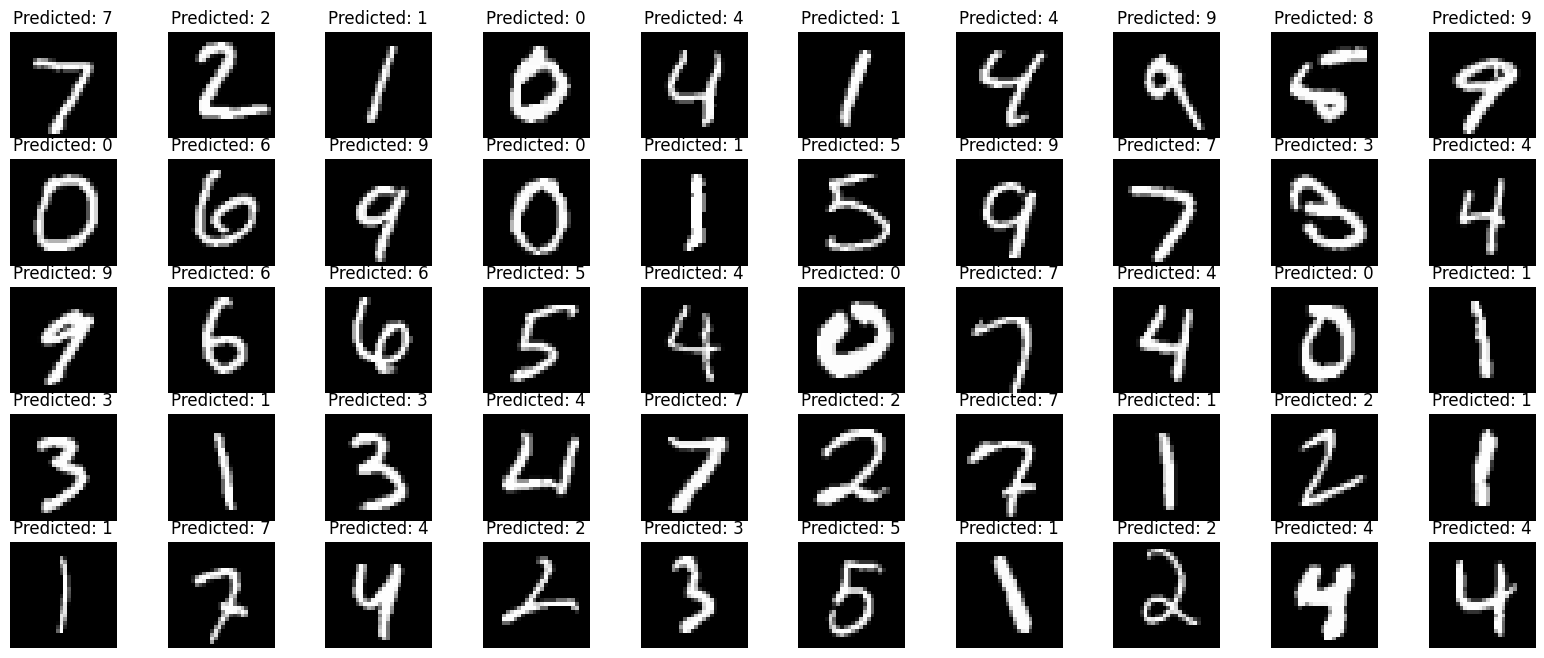

In [93]:

import matplotlib.pyplot as plt

# Assuming 'ten_image' is a tensor of shape (10, 1, 28, 28)
fig, axes = plt.subplots(5, 10, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(ten_image[i][0], cmap='gray')
    y_test_label = Test(model, ten_image)
    ax.set_title(f"Predicted: {y_test_label[i].argmax().item()}")
    ax.axis('off') # Hide axes ticks and labels
plt.show()
